In [2]:
# === LOAD REAL & SYNTHETIC DATA ===
import pandas as pd
import numpy as np

real_path  = "bean-clean.csv"          # real dataset
synth_path = "syn_outputs/syn_bean_merged.csv"     # synthetic dataset generated by CTGAN

real_df  = pd.read_csv(real_path)
synth_df = pd.read_csv(synth_path)

# --- Equalize sample sizes ---
# randomly select same number of samples as synthetic data (without replacement)
target_n = min(len(real_df), len(synth_df))
real_df  = real_df.sample(n=target_n, random_state=42).reset_index(drop=True)
synth_df = synth_df.sample(n=target_n, random_state=42).reset_index(drop=True)

print(f"Balanced comparison → {len(real_df)} real vs {len(synth_df)} synthetic samples")

display(real_df.head(3))
display(synth_df.head(3))


Balanced comparison → 2500 real vs 2500 synthetic samples


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,37109,694.497,239.859756,197.202290,1.216313,0.569261,37419,217.367537,0.787476,0.991715,0.966826,0.906228,0.006464,0.002689,0.821249,0.998895,SEKER
1,71483,1093.388,372.069831,245.107581,1.517986,0.752346,72960,301.686895,0.720413,0.979756,0.751388,0.810834,0.005205,0.001388,0.657452,0.998003,BARBUNYA
2,33168,680.621,234.315548,180.582754,1.297552,0.637220,33542,205.501361,0.761240,0.988850,0.899743,0.877028,0.007065,0.002578,0.769179,0.998049,SEKER


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,171415.5246,1423.6608,548.4059,389.8453,1.5199,0.7110,151040.8777,462.9029,0.7633,0.9917,0.8877,0.8186,0.0033,0.001,0.6493,0.9979,BOMBAY
1,135196.0591,1485.6204,490.7913,349.0672,1.5994,0.7922,144072.4154,446.6595,0.7490,0.9900,0.8232,0.7791,0.0039,0.001,0.6614,0.9943,BOMBAY
2,189502.6242,1432.5621,604.1357,368.4800,1.4862,0.7637,193014.9803,464.6547,0.7149,0.9901,0.8425,0.8024,0.0032,0.001,0.6755,0.9981,BOMBAY


In [3]:
import numpy as np
import pandas as pd

from scipy.stats import ks_2samp, wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", lambda v: f"{v:0.3f}")
sns.set_style("whitegrid")

def get_numeric_cols(df, drop_labels=('Class', 'label', 'Labels', 'Target', 'target')):
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Drop common label columns if they slipped in as numeric encodings
    for c in drop_labels:
        if c in cols:
            cols.remove(c)
    return cols

def align_columns(real_df, synth_df):
    # Use intersection of numeric columns present in both frames
    num_real = get_numeric_cols(real_df)
    num_syn  = get_numeric_cols(synth_df)
    common   = [c for c in num_real if c in num_syn]
    if not common:
        raise ValueError("No common numeric columns found between real_df and synth_df.")
    return real_df[common].copy(), synth_df[common].copy()

real_num, synth_num = align_columns(real_df, synth_df)
print(f"Using {len(real_num.columns)} numeric features:", list(real_num.columns))


Using 16 numeric features: ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [5]:
ks_rows = []
for col in real_num.columns:
    stat, p = ks_2samp(real_num[col].values, synth_num[col].values)
    ks_rows.append({"feature": col, "ks_stat": stat, "p_value": p})

ks_df = pd.DataFrame(ks_rows).sort_values("ks_stat")
display(ks_df)


,feature,ks_stat,p_value
9,Solidity,0.071,0.000
4,AspectRation,0.076,0.000
8,Extent,0.077,0.000
10,roundness,0.078,0.000
14,ShapeFactor3,0.078,0.000
11,Compactness,0.079,0.000
15,ShapeFactor4,0.081,0.000
5,Eccentricity,0.082,0.000
7,EquivDiameter,0.146,0.000
2,MajorAxisLength,0.146,0.000


In [6]:
w_rows = []
for col in real_num.columns:
    w = wasserstein_distance(real_num[col].values, synth_num[col].values)
    w_rows.append({"feature": col, "wasserstein": w})

wasser_df = pd.DataFrame(w_rows).sort_values("wasserstein")
display(wasser_df)


,feature,wasserstein
13,ShapeFactor2,0.000
12,ShapeFactor1,0.000
15,ShapeFactor4,0.001
9,Solidity,0.001
8,Extent,0.006
10,roundness,0.007
11,Compactness,0.009
5,Eccentricity,0.015
14,ShapeFactor3,0.016
4,AspectRation,0.037


In [7]:
corr_real  = real_num.corr()
corr_synth = synth_num.corr()

# Mean Absolute Correlation Difference across all pairs
macd = np.mean(np.abs(corr_real.values - corr_synth.values))
print(f"Mean Absolute Correlation Difference (MACD): {macd:0.3f}")

# Optional: per-feature average absolute correlation diff (how well each feature's correlations were preserved)
per_feat_macd = (np.abs(corr_real - corr_synth)).mean(axis=1).sort_values()
per_feat_macd = per_feat_macd.rename("mean_abs_corr_diff").to_frame()
display(per_feat_macd)


Mean Absolute Correlation Difference (MACD): 0.086


,mean_abs_corr_diff
MinorAxisLength,0.030
ShapeFactor1,0.045
Area,0.063
ConvexArea,0.064
EquivDiameter,0.075
ShapeFactor4,0.088
Extent,0.090
ShapeFactor2,0.092
Perimeter,0.095
Eccentricity,0.096


In [8]:
cov_rows = []
for col in real_num.columns:
    rmin, rmax = real_num[col].min(), real_num[col].max()
    syn_vals = synth_num[col].values
    within = np.mean((syn_vals >= rmin) & (syn_vals <= rmax)) * 100.0
    var_ratio = (np.var(syn_vals, ddof=1) / np.var(real_num[col].values, ddof=1)) if np.var(real_num[col].values, ddof=1) > 0 else np.nan
    cov_rows.append({"feature": col, "coverage_percent": within, "variance_ratio": var_ratio})

coverage_df = pd.DataFrame(cov_rows).sort_values("coverage_percent", ascending=False)
display(coverage_df)

print(f"\nAverage coverage %: {coverage_df['coverage_percent'].mean():0.2f}")
print(f"Average variance ratio: {coverage_df['variance_ratio'].mean():0.3f}")


,feature,coverage_percent,variance_ratio
1,Perimeter,99.760,1.841
6,ConvexArea,99.720,2.273
7,EquivDiameter,99.720,2.002
11,Compactness,99.680,0.819
0,Area,99.600,2.244
4,AspectRation,99.600,0.824
14,ShapeFactor3,99.560,0.810
5,Eccentricity,99.280,0.811
3,MinorAxisLength,99.200,2.106
2,MajorAxisLength,99.160,1.676



Average coverage %: 98.74
Average variance ratio: 1.415


In [9]:
summary = (ks_df.merge(wasser_df, on="feature")
                .merge(coverage_df, on="feature")
                .merge(per_feat_macd.reset_index().rename(columns={"index":"feature"}), on="feature"))
summary = summary[["feature", "ks_stat", "p_value", "wasserstein", "coverage_percent", "variance_ratio", "mean_abs_corr_diff"]]
display(summary.sort_values(["ks_stat", "wasserstein"]))


,feature,ks_stat,p_value,wasserstein,coverage_percent,variance_ratio,mean_abs_corr_diff
0,Solidity,0.071,0.000,0.001,96.480,1.347,0.099
1,AspectRation,0.076,0.000,0.037,99.600,0.824,0.101
2,Extent,0.077,0.000,0.006,97.200,1.184,0.090
3,roundness,0.078,0.000,0.007,99.080,0.882,0.125
4,ShapeFactor3,0.078,0.000,0.016,99.560,0.810,0.099
5,Compactness,0.079,0.000,0.009,99.680,0.819,0.099
6,ShapeFactor4,0.081,0.000,0.001,93.400,1.307,0.088
7,Eccentricity,0.082,0.000,0.015,99.280,0.811,0.096
8,EquivDiameter,0.146,0.000,31.022,99.720,2.002,0.075
9,MajorAxisLength,0.146,0.000,39.813,99.160,1.676,0.120


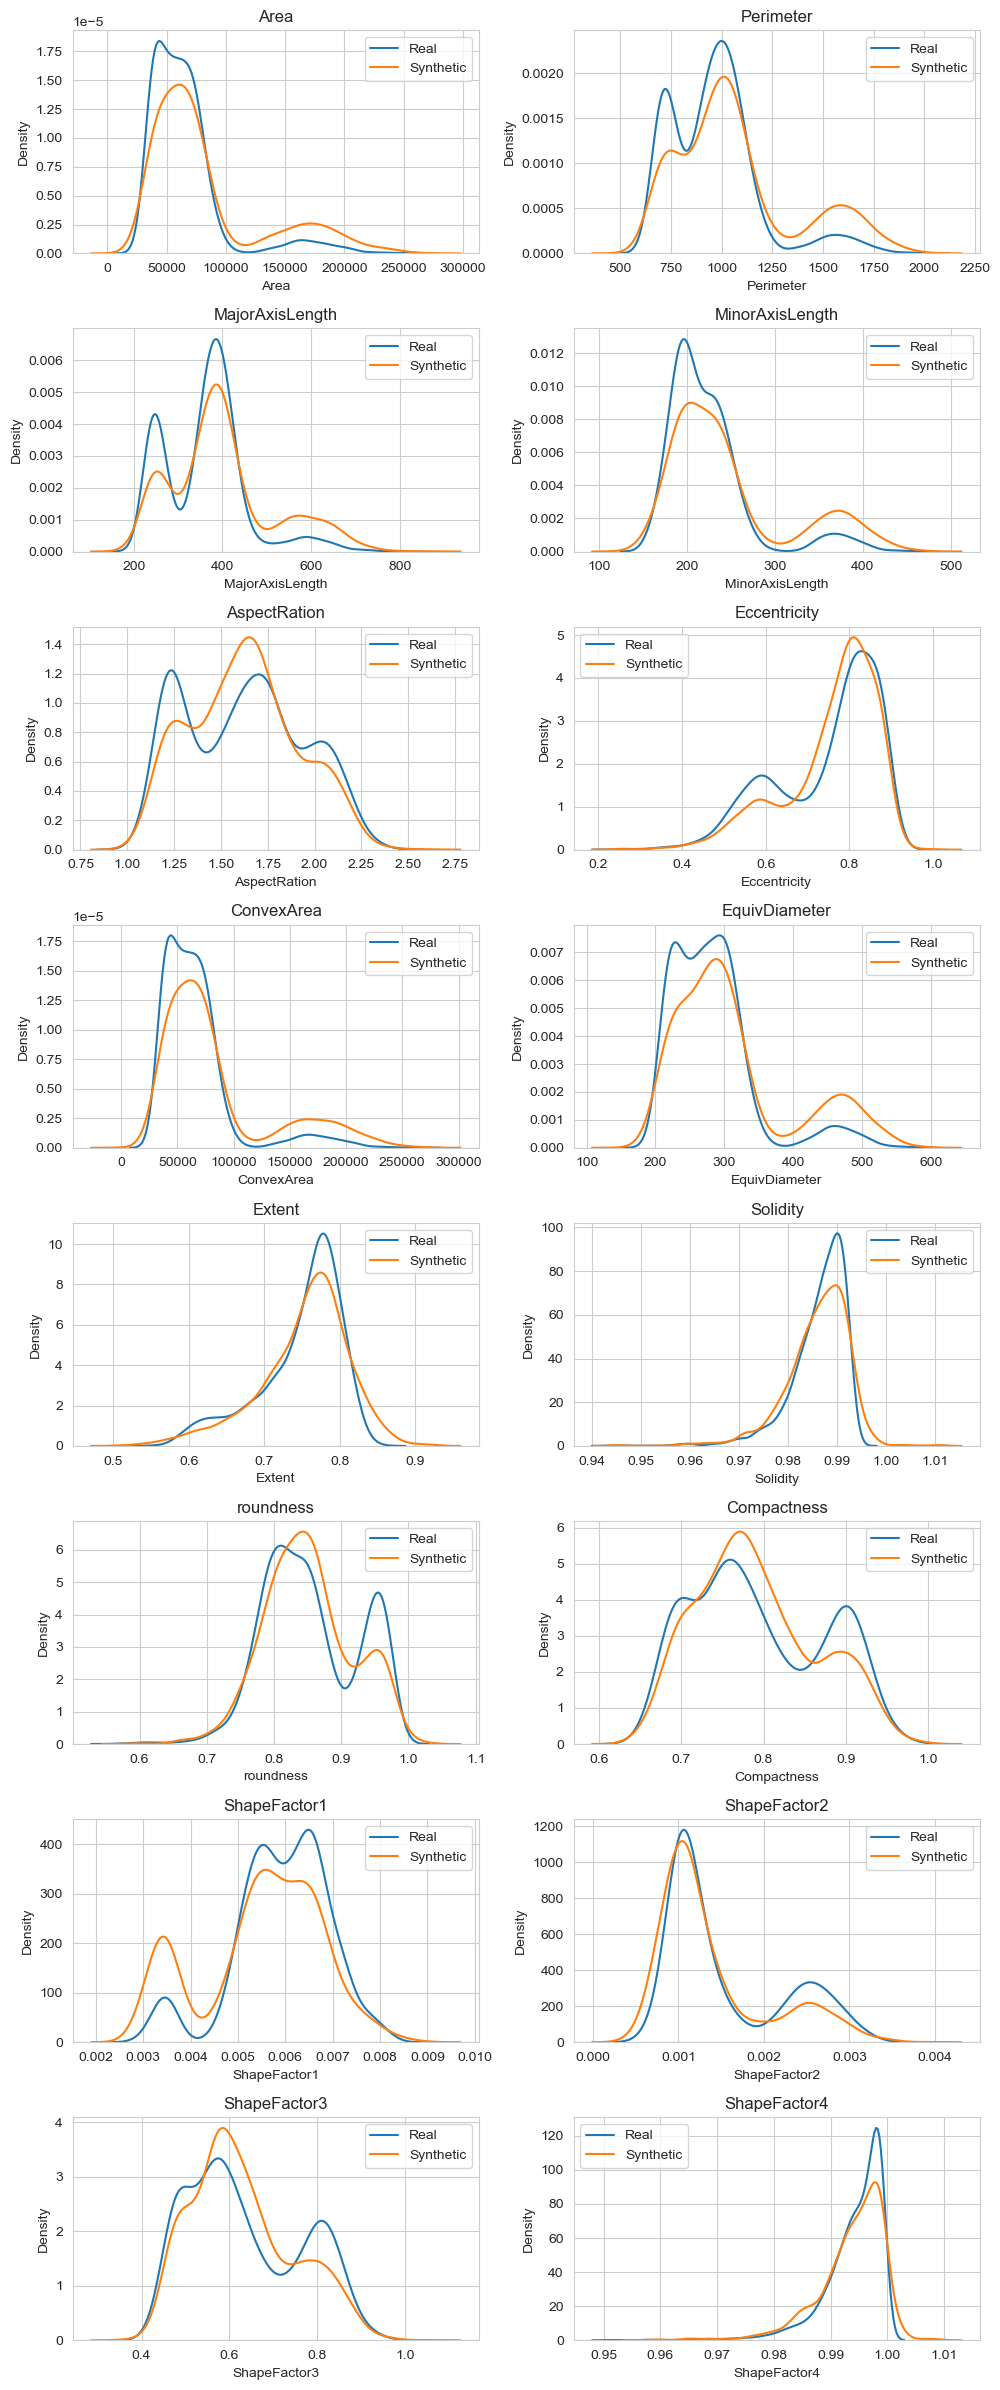

In [16]:
ncols = 2
nrows = int(np.ceil(len(real_num.columns)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3*nrows))
axes = axes.ravel()

for i, col in enumerate(real_num.columns):
    ax = axes[i]
    sns.kdeplot(real_num[col], ax=ax, label="Real", fill=False)
    sns.kdeplot(synth_num[col], ax=ax, label="Synthetic", fill=False)
    ax.set_title(col)
    ax.legend()

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


In [1]:
print(1)

1


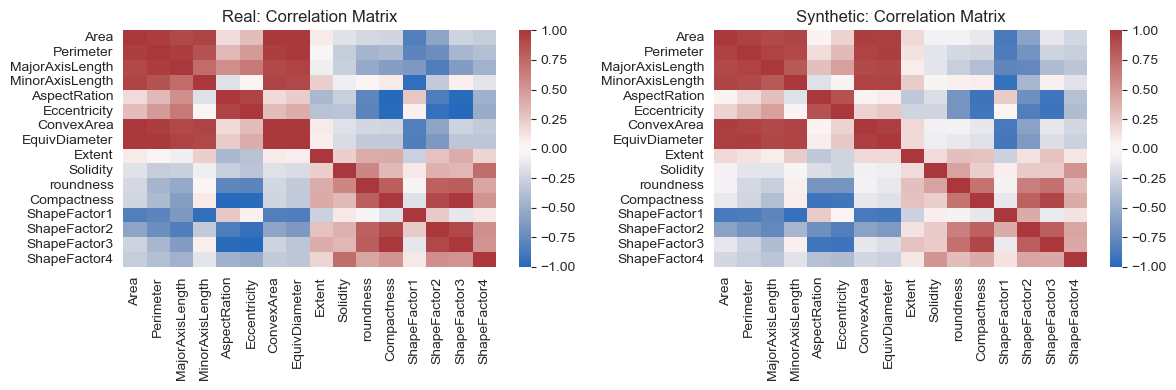

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(corr_real,  vmin=-1, vmax=1, cmap="vlag", center=0, ax=axes[0])
axes[0].set_title("Real: Correlation Matrix")
sns.heatmap(corr_synth, vmin=-1, vmax=1, cmap="vlag", center=0, ax=axes[1])
axes[1].set_title("Synthetic: Correlation Matrix")
plt.tight_layout()
plt.show()


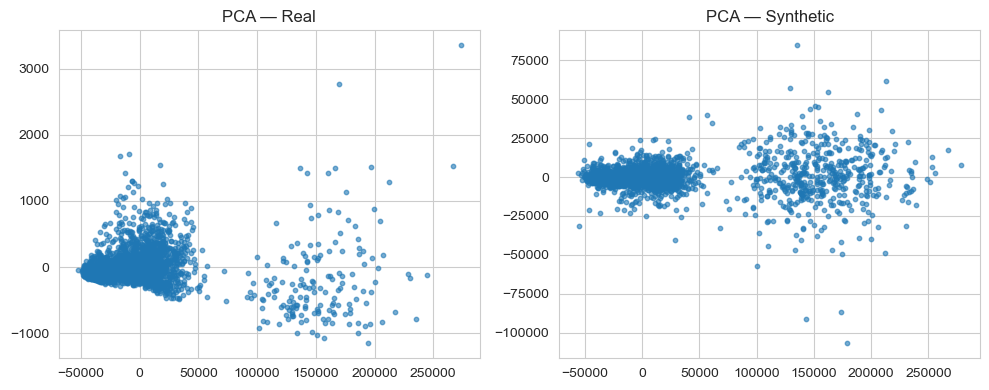

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2, random_state=42)
p_real  = pca.fit_transform(real_num.values)
p_synth = pca.transform(synth_num.values)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(p_real[:,0],  p_real[:,1],  s=10, alpha=0.6)
ax[0].set_title("PCA — Real")
ax[1].scatter(p_synth[:,0], p_synth[:,1], s=10, alpha=0.6)
ax[1].set_title("PCA — Synthetic")
plt.tight_layout()
plt.show()

# t-SNE (note: slower; you can reduce perplexity or samples if needed)
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
ts_real  = tsne.fit_transform(real_num.values)
ts_synth = tsne.fit_transform(synth_num.values)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(ts_real[:,0],  ts_real[:,1],  s=10, alpha=0.6)
ax[0].set_title("t-SNE — Real")
ax[1].scatter(ts_synth[:,0], ts_synth[:,1], s=10, alpha=0.6)
ax[1].set_title("t-SNE — Synthetic")
plt.tight_layout()
plt.show()
